In [24]:
# import libraries

# main
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 28
import pandas as pd
import seaborn as sns
import time
import os

# pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# grid-search
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# machine learning models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# import skorch
from skorch import NeuralNetRegressor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# dimensionality reduction
from sklearn.decomposition import PCA
# from yellowbrick.model_selection import FeatureImportances

# neural network
# from skorch import NeuralNetRegressor
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

# evaluation metrics
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from yellowbrick.model_selection import ValidationCurve

import warnings # supress warnings
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(transform_output="pandas")

sns.set_theme(style='darkgrid')

In [25]:
# Set the default text font size
plt.rc('font', size=18)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=16)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=14)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=14)
# Set the legend font size
plt.rc('legend', fontsize=14)
# Set the font size of the figure title
plt.rc('figure', titlesize=18)

font = {'family' : 'Cambria',
        'weight' : 'normal'}
plt.rc('font', **font)

In [26]:
def eval_metrics(actual,pred, verbose=True):
    rmse = np.sqrt(mean_squared_error(actual,pred))
    mae  = mean_absolute_error(actual,pred)
    mse  = mean_squared_error(actual,pred)
    r2   = r2_score(actual,pred)
    if verbose:
        print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

    return rmse, mae, mse, r2

# Data Pre-processing

In [27]:
df = pd.read_csv('combined_last.csv',header=0, delimiter= ';')
#df = pd.read_excel('combined.xlsx',header=0)
df.head()

,Mach,YoungsModulus1,Poisson1,Density1,YoungsModulus2,Poisson2,Density2,YoungsModulus3,Poisson3,Density3,YoungsModulus4,Poisson4,Density4,YoungsModulus5,Poisson5,Density5,Flutter Speed,Mass,Flutter Frequency
0,0.001,800000000,0.35,870.0,350000000,0.35,0.01,55000000000,0.3,2700.0,700000,0.25,0.0005,800000000,0.35,870.0,60.781334,0.340962,31.713015
1,0.100,800000000,0.35,870.0,350000000,0.35,0.01,55000000000,0.3,2700.0,700000,0.25,0.0005,800000000,0.35,870.0,60.883557,0.340962,31.665279
2,0.200,800000000,0.35,870.0,350000000,0.35,0.01,55000000000,0.3,2700.0,700000,0.25,0.0005,800000000,0.35,870.0,61.184623,0.340962,31.523103
3,0.300,800000000,0.35,870.0,350000000,0.35,0.01,55000000000,0.3,2700.0,700000,0.25,0.0005,800000000,0.35,870.0,61.685456,0.340962,31.282932
4,0.400,800000000,0.35,870.0,350000000,0.35,0.01,55000000000,0.3,2700.0,700000,0.25,0.0005,800000000,0.35,870.0,62.378835,0.340962,30.940801


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mach               1984 non-null   float64
 1   YoungsModulus1     1984 non-null   int64  
 2   Poisson1           1984 non-null   float64
 3   Density1           1984 non-null   float64
 4   YoungsModulus2     1984 non-null   int64  
 5   Poisson2           1984 non-null   float64
 6   Density2           1984 non-null   float64
 7   YoungsModulus3     1984 non-null   int64  
 8   Poisson3           1984 non-null   float64
 9   Density3           1984 non-null   float64
 10  YoungsModulus4     1984 non-null   int64  
 11  Poisson4           1984 non-null   float64
 12  Density4           1984 non-null   float64
 13  YoungsModulus5     1984 non-null   int64  
 14  Poisson5           1984 non-null   float64
 15  Density5           1984 non-null   float64
 16  Flutter Speed      1984 

In [29]:
df.describe()

,Mach,YoungsModulus1,Poisson1,Density1,YoungsModulus2,Poisson2,Density2,YoungsModulus3,Poisson3,Density3,YoungsModulus4,Poisson4,Density4,YoungsModulus5,Poisson5,Density5,Flutter Speed,Mass,Flutter Frequency
count,1984.000000,1.984000e+03,1984.000000,1984.000000,1.984000e+03,1984.000000,1984.000000,1.984000e+03,1984.000000,1984.000000,1.984000e+03,1984.000000,1984.000000,1.984000e+03,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000
mean,0.450252,1.091694e+09,0.399475,926.172253,4.709130e+08,0.399131,0.028780,6.931812e+10,0.329712,2820.784829,9.842468e+05,0.298930,0.000968,1.088044e+09,0.398717,926.839039,70.724736,0.357969,30.291642
std,0.287512,1.747783e+08,0.028960,34.694023,7.161409e+07,0.028933,0.011707,8.639883e+09,0.017380,71.748631,1.713024e+05,0.028996,0.000290,1.715591e+08,0.029079,35.740071,6.499066,0.007175,7.545881
min,0.001000,8.000000e+08,0.350000,870.000000,3.500000e+08,0.350000,0.010000,5.500000e+10,0.300000,2700.000000,7.000000e+05,0.250000,0.000500,8.000000e+08,0.350000,870.000000,58.903219,0.340962,10.272625
25%,0.200000,9.417750e+08,0.374000,897.218750,4.107000e+08,0.374000,0.018775,6.183000e+10,0.315000,2756.073400,8.361000e+05,0.273000,0.000700,9.450000e+08,0.372000,895.256600,65.784841,0.352983,30.573735
50%,0.500000,1.085000e+09,0.399000,924.500000,4.715000e+08,0.399000,0.027600,6.933000e+10,0.330000,2820.490100,9.880500e+05,0.298000,0.000950,1.091000e+09,0.398500,926.865300,70.220191,0.358096,32.660571
75%,0.700000,1.242000e+09,0.425000,955.656250,5.322000e+08,0.424000,0.038725,7.716000e+10,0.345000,2884.906800,1.124000e+06,0.324000,0.001200,1.237000e+09,0.424250,957.992700,74.261697,0.363043,34.561380
max,0.900000,1.399000e+09,0.449000,986.875000,5.947000e+08,0.449000,0.049400,8.425000e+10,0.360000,2946.993400,1.283000e+06,0.349000,0.001500,1.384000e+09,0.449000,989.065100,91.783236,0.375030,37.861400


In [30]:
# Prepare X and y based on the given criteria using df
X = df.iloc[:, 0:16]  # The first 15 parameters are input features (excluding Index)
y = df[['Flutter Speed']]  # Specified output features

# Print the shapes of X and y
print('Input shape: ', X.shape)
print('Output shape: ', y.shape)


Input shape:  (1984, 16)
Output shape:  (1984, 1)


In [31]:
from sklearn.ensemble import IsolationForest

def clean_outliers(X, y, contamination=0.1):
    # Combine X and y for outlier detection
    data = pd.concat([X, y], axis=1)

    # Fit the model
    clf = IsolationForest(contamination=contamination, random_state=42)
    clf.fit(data)

    # Predict the outliers
    y_pred = clf.predict(data)

    # Filter the data
    mask = y_pred != -1
    X_clean = X[mask]
    y_clean = y[mask]

    return X_clean, y_clean

# Clean outliers from X and y
X_clean, y_clean = clean_outliers(X, y, contamination=0.1)

print(f"Original X shape: {X.shape}")
print(f"Cleaned X shape: {X_clean.shape}")
print(f"Original y shape: {y.shape}")
print(f"Cleaned y shape: {y_clean.shape}")

Original X shape: (1984, 16)
Cleaned X shape: (1785, 16)
Original y shape: (1984, 1)
Cleaned y shape: (1785, 1)


In [32]:
X, y = X_clean, y_clean

In [33]:
# split the dataset into train_val and test parts
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, shuffle = True, random_state=1773)

# print
print('Train input shape: ', X_train.shape)
print('Train output shape: ', y_train.shape)
print('Test input shape: ', X_test.shape)
print('Test output shape: ', y_test.shape)

Train input shape:  (1517, 16)
Train output shape:  (1517, 1)
Test input shape:  (268, 16)
Test output shape:  (268, 1)


In [34]:
X_train.head()

,Mach,YoungsModulus1,Poisson1,Density1,YoungsModulus2,Poisson2,Density2,YoungsModulus3,Poisson3,Density3,YoungsModulus4,Poisson4,Density4,YoungsModulus5,Poisson5,Density5
151,0.2,896300000,0.444,928.125,571300000,0.376,0.0263,78750000000,0.307,2792.4534,1092000,0.268,0.0009,1111000000,0.387,908.7718
1983,0.9,992800000,0.439,921.125,536600000,0.389,0.0254,70080000000,0.359,2916.3259,1101000,0.294,0.0011,1322000000,0.365,898.6526
685,0.3,1003000000,0.413,897.375,368200000,0.378,0.0449,74250000000,0.356,2872.7300,703400,0.340,0.0011,1029000000,0.382,926.9203
793,0.3,914100000,0.354,940.000,530500000,0.449,0.0166,61670000000,0.304,2940.5292,990900,0.301,0.0014,1257000000,0.383,955.3529
137,0.8,803600000,0.419,920.375,541800000,0.398,0.0242,75580000000,0.341,2780.1263,1040000,0.338,0.0008,1069000000,0.369,903.6022


In [35]:
y_train.head()

,Flutter Speed
151,72.147537
1983,77.786948
685,69.264688
793,64.790803
137,85.850336


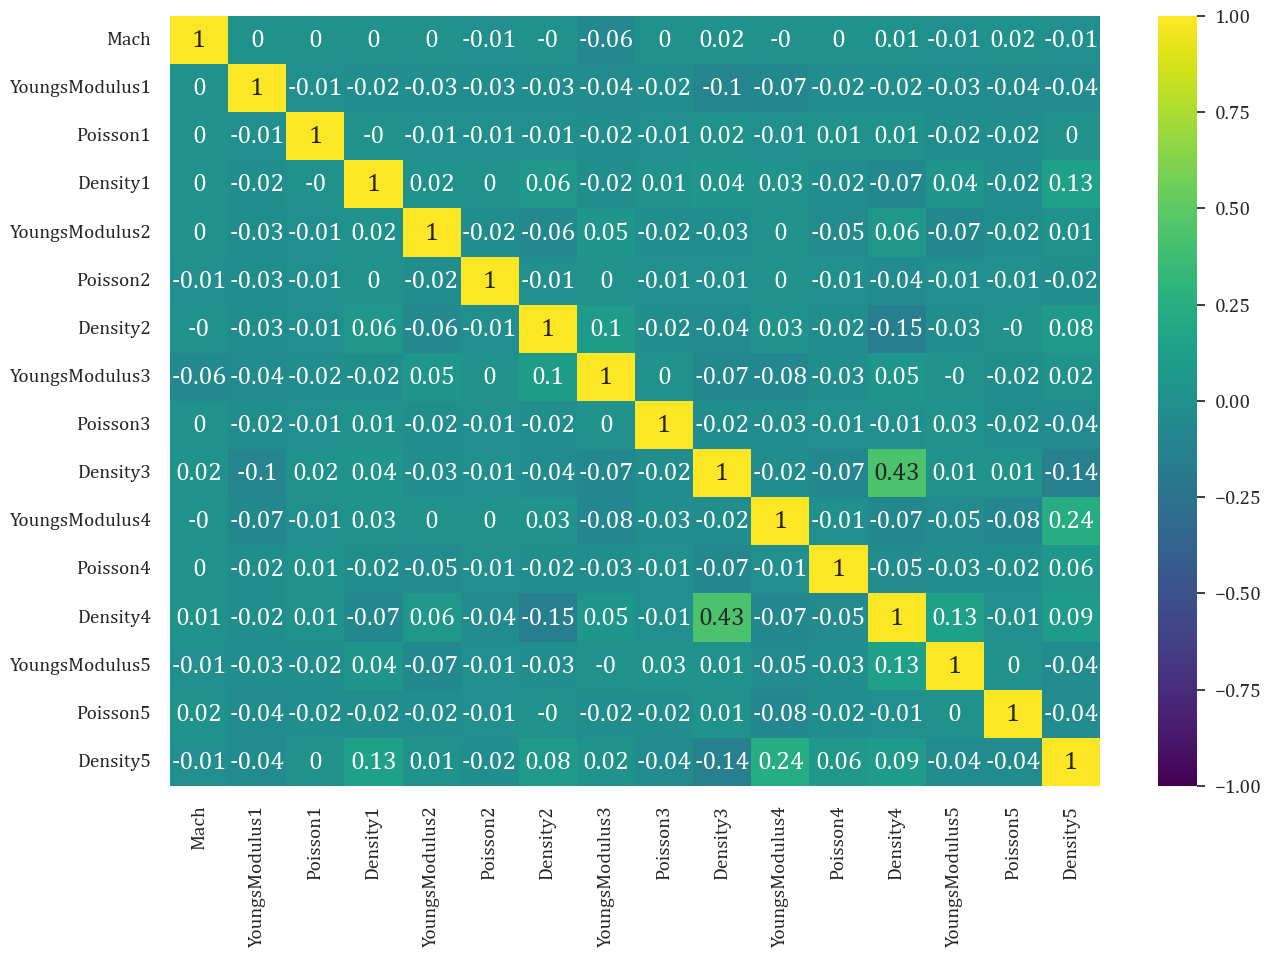

In [36]:
# Disable LaTeX rendering in Matplotlib
plt.rc('text', usetex=False)

# Assuming you have already split the data into training and test sets
# Here we use the entire X dataframe for the heatmap, replace X with X_train if you have split the data
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(X.corr().round(2), vmin=-1, vmax=1, annot=True, cmap='viridis', 
                      xticklabels=X.columns, yticklabels=X.columns)
plt.savefig('l3_3D_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()


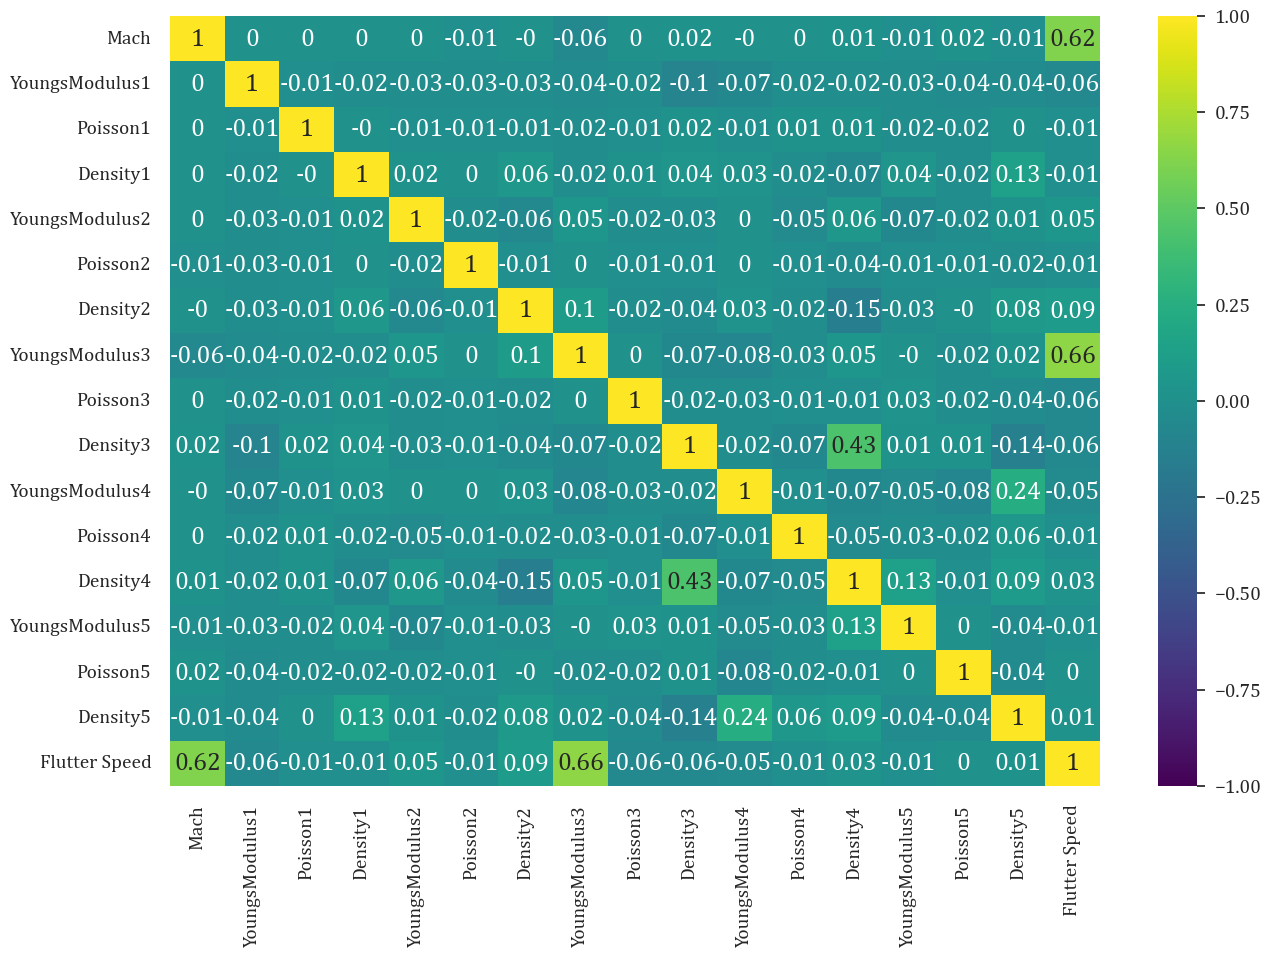

In [37]:
# Combine all data (features and targets) for the heatmap
combined_df = pd.concat([X, y], axis=1)

# Disable LaTeX rendering in Matplotlib
plt.rc('text', usetex=False)

# Create the heatmap with all data
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(combined_df.corr().round(2), vmin=-1, vmax=1, annot=True, cmap='viridis', 
                      xticklabels=combined_df.columns, yticklabels=combined_df.columns)
plt.savefig('l3_3D_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()


In [38]:

flutter_speed_mean = y_train['Flutter Speed'].mean(); flutter_speed_std = y_train['Flutter Speed'].std()

y_train['Flutter Speed'] = (y_train['Flutter Speed'] - flutter_speed_mean) / flutter_speed_std

y_test['Flutter Speed'] = (y_test['Flutter Speed'] - flutter_speed_mean) / flutter_speed_std


In [39]:
# Generate LaTeX-formatted strings for feature names and target variables
plot_names_X = list(X.columns)
plot_names_y = []

# Store LaTeX-formatted strings in the list

plot_names_y.append(r"$\text{Flutter Speed}$")


In [40]:
# '''
#     BOX PLOTS
# '''

# def draw_plot(ax, data, offset ,edge_color, fill_color, title):
#     pos = np.arange(1)+offset 
#     bp = ax.boxplot(data, positions=pos, widths=0.3, patch_artist=True, sym='+')

#     ax.set_xticks([-0.2,0.2])
#     ax.set_xticklabels(['Exact', 'Prediction'])
#     ax.set_ylabel(title)
#     ax.yaxis.grid(True) # Hide the horizontal gridlines
#     ax.xaxis.grid(True) # Show the vertical gridlines

#     for element in ['boxes', 'whiskers', 'fliers', 'caps']:
#         plt.setp(bp[element], color=edge_color)

#     plt.setp(bp['medians'], color='r')

#     for patch in bp['boxes']:
#         patch.set(facecolor=fill_color)

# fig = plt.figure(figsize=(12,12), constrained_layout=True)

# gs = gridspec.GridSpec(3, 4)
# gs.update(wspace=0.8,hspace=0.3)
# ax1 = plt.subplot(gs[0, 0:2])
# ax2 = plt.subplot(gs[0, 2:])
# ax3 = plt.subplot(gs[1, 0:2])
# ax4 = plt.subplot(gs[1, 2:])
# ax5 = plt.subplot(gs[2, 1:3])
# ax = [ax1,ax2,ax3,ax4,ax5]
# plt.tight_layout()

# for i in range(5):
#     draw_plot(ax[i], targetbox[:,i], -0.2, "black", "wheat", label[i])
#     draw_plot(ax[i], predbox[:,i], +0.2, "black",  'aquamarine', label[i])
# #fig.savefig('sboom_boxplot.png',dpi=200)

In [41]:
# create empty dictionary to collect the scores
scores_dict = {'LR':{'Train': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}, 'Test': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}},
                'RF':{'Train': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}, 'Test': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}},
                'GBR':{'Train': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}, 'Test': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}},
                'X-GBR':{'Train': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}, 'Test': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}},
                'SVR':{'Train': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}, 'Test': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}},
                'MLP':{'Train': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}, 'Test': {'RMSE': None, 'MAE': None, 'MSE': None, 'R2': None}}}

In [42]:
# create a random forest model without GS
rf_base = MultiOutputRegressor(RandomForestRegressor(random_state=42))

# create a pipeline
rf_base_pipe = make_pipeline(rf_base)

start_time = time.time()
# fit the model
rf_base_pipe.fit(X_train, y_train)
end_time = time.time()

# print accuracies
print("Train Accuracy: %.6f" % (rf_base_pipe.score(X_train, y_train)))
print("Test Accuracy: %.6f" % (rf_base_pipe.score(X_test, y_test)))

# look at parameters used by current random forest regressor
print('\nDefault Parameters for Random Forest Regressor:\n')
for i in range(len(rf_base_pipe.named_steps['multioutputregressor'].estimator.get_params().keys())):
    print('Parameter Name: {:24.25s} = {:.25s}' .format(list(rf_base_pipe.named_steps['multioutputregressor'].estimator.get_params().keys())[i],str(list(rf_base_pipe.named_steps['multioutputregressor'].estimator.get_params().values())[i])))


# Compute the training time
training_time = end_time - start_time

print("Training Time:", training_time, "seconds")

Train Accuracy: 0.997879
Test Accuracy: 0.978363

Default Parameters for Random Forest Regressor:

Parameter Name: bootstrap                = True
Parameter Name: ccp_alpha                = 0.0
Parameter Name: criterion                = squared_error
Parameter Name: max_depth                = None
Parameter Name: max_features             = 1.0
Parameter Name: max_leaf_nodes           = None
Parameter Name: max_samples              = None
Parameter Name: min_impurity_decrease    = 0.0
Parameter Name: min_samples_leaf         = 1
Parameter Name: min_samples_split        = 2
Parameter Name: min_weight_fraction_leaf = 0.0
Parameter Name: n_estimators             = 100
Parameter Name: n_jobs                   = None
Parameter Name: oob_score                = False
Parameter Name: random_state             = 42
Parameter Name: verbose                  = 0
Parameter Name: warm_start               = False
Training Time: 3.0437846183776855 seconds


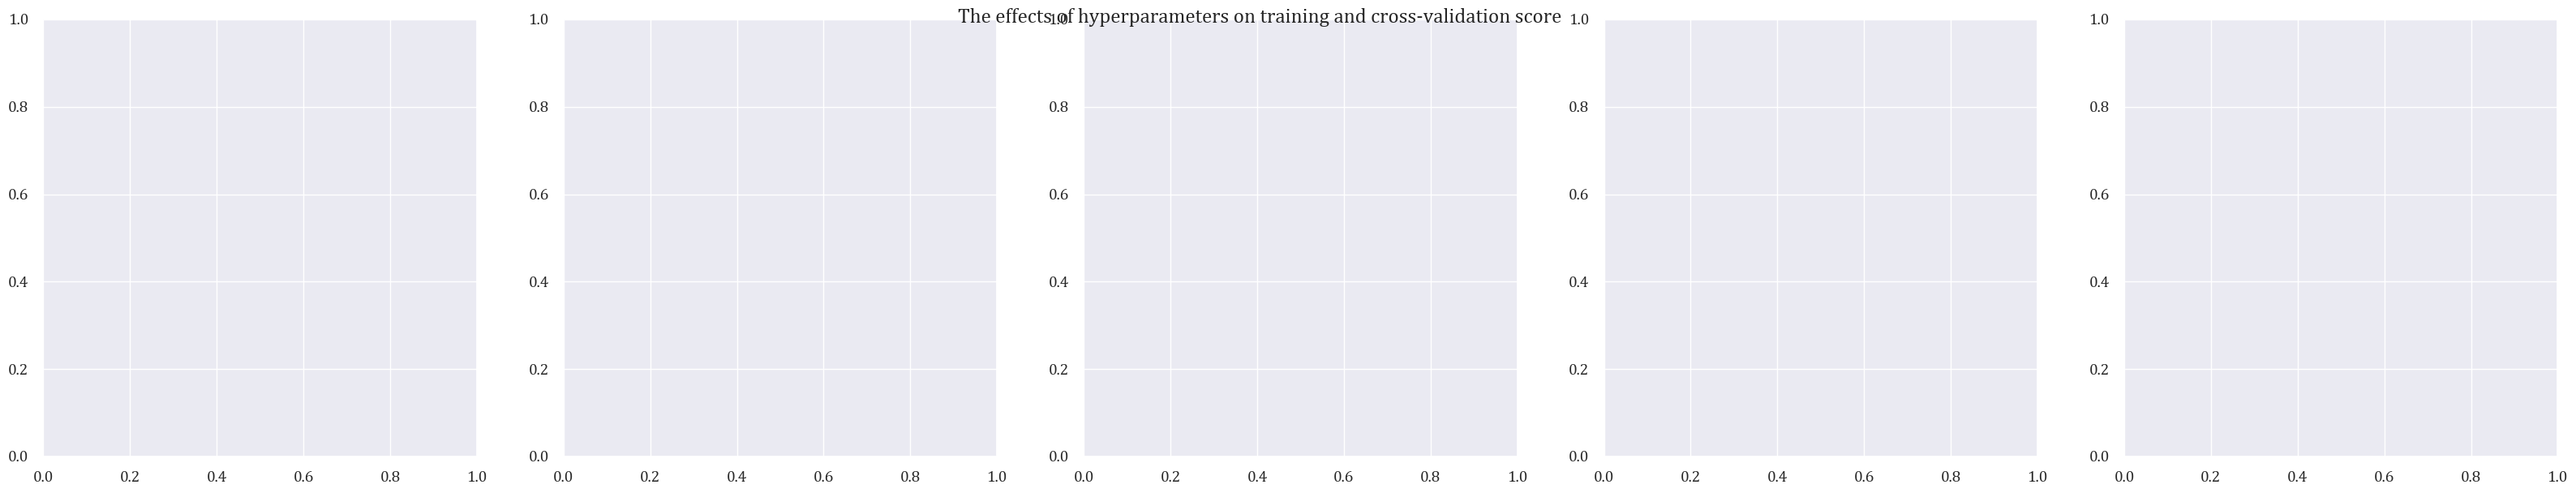

In [43]:
# figure properties
fig, axes = plt.subplots(y_train.shape[1], 5, figsize=(40, 7*y_train.shape[1]), sharey=False)
fig.suptitle('The effects of hyperparameters on training and cross-validation score', y = 0.90, fontsize=18)

# create a cross-validation folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 1773)

# specify range of hyperparameters to tune (for GBR)
param_names = ["multioutputregressor__estimator__n_estimators", "multioutputregressor__estimator__max_depth", "multioutputregressor__estimator__min_samples_split",
                "multioutputregressor__estimator__min_samples_leaf", "multioutputregressor__estimator__max_features"] 
convert_names = True # this is used in pipeline (not important)

# determine the range of the selected parameters
# n_estimators      = [int(x) for x in np.linspace(80,200,3)] # the number of trees in the forest
# max_depth         = [int(x) for x in np.linspace(20,30,2)]  # the maximum depth of the tree.
# min_samples_split = [int(x) for x in np.linspace(1,3,3)]    # the minimum number of samples required to split an internal node (default = 2)
# min_samples_leaf  = [int(x) for x in np.linspace(1,3,3)]    # the minimum number of samples required to be at a leaf node. (default = 1)
# max_features      = [int(x) for x in np.linspace(2,4,3)]    # the number of features to consider when looking for the best split (default = 1.0)

n_estimators      = [int(x) for x in np.linspace(170,180,2)] # the number of trees in the forest
max_depth         = [int(x) for x in np.linspace(9,10,2)]  # the maximum depth of the tree.
min_samples_split = [int(x) for x in np.linspace(2,3,2)]    # the minimum number of samples required to split an internal node (default = 2)
min_samples_leaf  = [int(x) for x in np.linspace(1,2,2)]    # the minimum number of samples required to be at a leaf node. (default = 1)
max_features      = [int(x) for x in np.linspace(10,20,2)]    # the number of features to consider when looking for the best split (default = 1.0)

# collect all parameters into a list
param_ranges = [n_estimators,
                max_depth,
                min_samples_split,
                min_samples_leaf,
                max_features
                ]  

# create a random forest estimator
rf_base = make_pipeline(MultiOutputRegressor(RandomForestRegressor(random_state=42)))

In [44]:
# add 'regressor__' string to hyperparameter names
if convert_names:
    param_names = ['regressor__estimator__' + name[33:] for name in tuple(param_names)]
convert_names = False

# specify range of hyperparameters to tune (for GBR)
hyper_params = dict(zip(param_names,param_ranges))

# create a random forest model
rf_base = MultiOutputRegressor(RandomForestRegressor(random_state=42))

# call GridSearchCV()
model_cv_rf = GridSearchCV(estimator = Pipeline([
                            ('regressor', rf_base)]),
                            param_grid = hyper_params, 
                            scoring = 'r2',
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

# fit the model
model_cv_rf.fit(X_train, y_train)

# put cv results into a dataframe
cv_results = pd.DataFrame(model_cv_rf.cv_results_)

# print test and train accuracy
print("Train Accuracy: %.6f" % (model_cv_rf.best_estimator_.score(X_train, y_train)))
print("Test Accuracy: %.6f" % (model_cv_rf.best_estimator_.score(X_test, y_test)))

# look at parameters used by current random forest
print('\nBest Parameters for Random Forest:\n')
for i in range(len(model_cv_rf.best_estimator_.named_steps['regressor'].estimator.get_params().keys())):
    print('Parameter Name: {:24.25s} = {:.25s}' .format(list(model_cv_rf.best_estimator_.named_steps['regressor'].estimator.get_params().keys())[i],str(list(model_cv_rf.best_estimator_.named_steps['regressor'].estimator.get_params().values())[i])))

# look at the best parameters used by current random forest
print('\nBest Parameters for Random Forest:\n', model_cv_rf.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Train Accuracy: 0.997383
Test Accuracy: 0.978169

Best Parameters for Random Forest:

Parameter Name: bootstrap                = True
Parameter Name: ccp_alpha                = 0.0
Parameter Name: criterion                = squared_error
Parameter Name: max_depth                = 10
Parameter Name: max_features             = 20
Parameter Name: max_leaf_nodes           = None
Parameter Name: max_samples              = None
Parameter Name: min_impurity_decrease    = 0.0
Parameter Name: min_samples_leaf         = 1
Parameter Name: min_samples_split        = 3
Parameter Name: min_weight_fraction_leaf = 0.0
Parameter Name: n_estimators             = 170
Parameter Name: n_jobs                   = None
Parameter Name: oob_score                = False
Parameter Name: random_state             = 42
Parameter Name: verbose                  = 0
Parameter Name: warm_start               = False

Best Parameters for Random Forest:
 {'regre

FileNotFoundError: [Errno 2] No such file or directory: 'images/3D_rf_feat_imp.png'

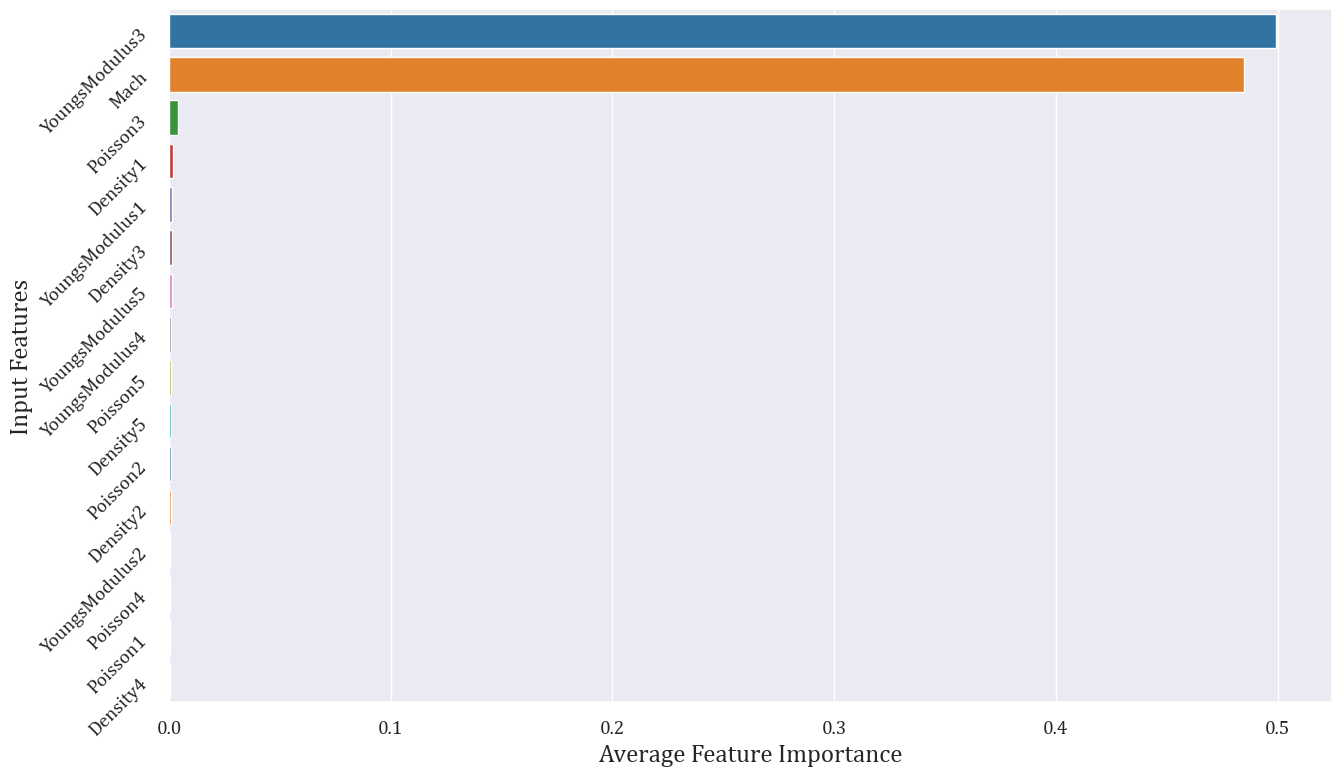

In [46]:
# collect the feature importance through estimators on the best model
feature_importance_rf = [] 
for reg in model_cv_rf.best_estimator_.named_steps['regressor'].estimators_:
    feature_importance_rf.append(reg.feature_importances_)

# take average of the feature importance
avg_feature_importance_rf = np.mean(feature_importance_rf, axis=0)
# put it into a dataframe
feat_imp = pd.DataFrame()
feat_imp['Index'] = plot_names_X #range(1,X_train.shape[1]+1)
feat_imp['Score'] = avg_feature_importance_rf

# figure properties
fig, ax = plt.subplots(figsize =(15, 9))

# horizontal bar plot
ax = sns.barplot(x='Score',
            y="Index", data=feat_imp,
            order=feat_imp.sort_values('Score', ascending=False).Index, orient='h', palette='tab10')
plt.xlabel("Average Feature Importance")
plt.ylabel("Input Features")
#plt.title('Average Feature Importance using Best Random Forest Regressor')
plt.yticks(rotation = 45)
plt.savefig('images/3D_rf_feat_imp.png',dpi=200, bbox_inches='tight');
plt.show()

In [ ]:
import joblib

# Save the fitted model and preprocessing pipelines
joblib.dump(model_cv_rf, 'flutter_multi_RF.pkl')